Using downloaded and verified file: binarized_mnist/binarized_mnist_train.amat
Using downloaded and verified file: binarized_mnist/binarized_mnist_valid.amat
Using downloaded and verified file: binarized_mnist/binarized_mnist_test.amat


0

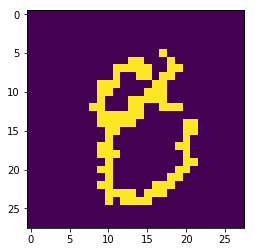

In [0]:
# -*- coding: utf-8 -*-
"""
Created on Tue Apr 16 09:52:14 2019

@author: karm2204
"""



#####         https://chrisorm.github.io/VAE-pyt.html
#             Variational Autoencoder in Pytorch
#             https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/variational_autoencoder/main.py
#             https://github.com/bobchennan/VAE_NBP/blob/master/vae_dp.py
#             https://github.com/pytorch/examples/blob/master/vae/main.py

from __future__ import print_function
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torchvision.utils import save_image
from torch.autograd import Variable
from sklearn.mixture import BayesianGaussianMixture
import torch.optim as optim
import torch.utils.data
import argparse
from torchvision.datasets import utils
import torch.utils.data as data_utils
import torch
import os
import numpy as np
from torch import nn
from torch.nn.modules import upsampling
from torch.functional import F
from torch.optim import Adam


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_printoptions(precision=8)


# Hyper-parameters
batch_size = 128
learning_rate = 3e-4
image_size = 784
h_dim = 400
z_dim = 100
num_epochs = 20


#%%

def get_data_loader(dataset_location, batch_size):
    URL = "http://www.cs.toronto.edu/~larocheh/public/datasets/binarized_mnist/"
    # start processing
    def lines_to_np_array(lines):
        return np.array([[int(i) for i in line.split()] for line in lines])
    splitdata = []
    for splitname in ["train", "valid", "test"]:
        filename = "binarized_mnist_%s.amat" % splitname
        filepath = os.path.join(dataset_location, filename)
        utils.download_url(URL + filename, dataset_location)
        with open(filepath) as f:
            lines = f.readlines()
        x = lines_to_np_array(lines).astype('float32')
        x = x.reshape(x.shape[0], 1, 28, 28)
        # pytorch data loader
        dataset = data_utils.TensorDataset(torch.from_numpy(x))
        dataset_loader = data_utils.DataLoader(x, batch_size=batch_size, shuffle=splitname == "train")
        splitdata.append(dataset_loader)
    return splitdata

train_loader, valid_loader, test_loader = get_data_loader("binarized_mnist", batch_size)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
for x in train_loader:
    plt.imshow(x[0, 0])
    break
    
torch.cuda.memory_allocated(device)

In [0]:
next(enumerate(train_loader))[1].size()
torch.cuda.memory_allocated(device)

0

In [0]:
#%%
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=100):
        super(VAE, self).__init__()
        
#         self.encoder = nn.Sequential(nn.Linear(image_size, h_dim),\
#                                 nn.ReLU()\
#                                )
        self.encoder= nn.Sequential(nn.Conv2d(1,32,3),\
                                    nn.ELU(),\
                                    nn.AvgPool2d(2,2),\
                                    nn.Conv2d(32,64,3),\
                                    nn.ELU(),\
                                    nn.AvgPool2d(2,2),\
                                    nn.Conv2d(64,256,5),\
                                    nn.ELU(),\
                                    )
#         self.fc_1 = nn.Linear(image_size, h_dim)
        self.fc_1 = nn.Linear(256, z_dim)
        self.fc_2 = nn.Linear(256, z_dim)

        self.fc_3 = nn.Linear(z_dim, 256)
#         self.fc_5 = nn.Linear(h_dim, image_size)
        self.decoder= nn.Sequential(nn.ELU(),\
                                    nn.Conv2d(256,64,5, padding = 4),\
                                    nn.ELU(),\
                                    nn.UpsamplingBilinear2d(scale_factor=2),\
                                    nn.Conv2d(64, 32, 3, padding=2),\
                                    nn.ELU(),\
                                    nn.UpsamplingBilinear2d(scale_factor=2),\
                                    nn.Conv2d(32, 16, 3, padding=2),\
                                    nn.ELU(),\
                                    nn.Conv2d(16, 1, 3, padding=2),\
                                    nn.Sigmoid()
                                    )
        
    """ Encode a batch of samples, and return posterior parameters for each point."""    
    def encode(self, x):
#         h_1 = F.relu(self.fc_1(x))
      h_1 = self.encoder(x)
      return self.fc_1(h_1.view(-1,256)), self.fc_2(h_1.view(-1,256))


    """ Reparameterisation trick to sample z values. 
        This is stochastic during training,  and returns the mode during evaluation.
        For each training sample (we get 128 batched at a time)
        - take the current learned mu, stddev for each of the z_dim 
        (in the pytorch VAE example, this is 20, z_dim = 20)
          dimensions and draw a random sample from that distribution
        - the whole network is trained so that these randomly drawn
          samples decode to output that looks like the input
        - which will mean that the std, mu will be learned
          *distributions* that correctly encode the inputs
        - due to the additional KLD term (see loss_function() below)
          the distribution will tend to unit Gaussians
        Parameters
        ----------
        mu : [128, z_dim] mean matrix
        logvar : [128, z_dim] variance matrix
        Returns
        -------
        During training random sample from the learned ZDIMS-dimensional
        normal distribution; during inference its mean.
        """
    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar/2)
        eps = torch.randn_like(std)
        return mu + eps * std


    """ Decode a batch of latent variables"""
    def decode(self, z):
    #        h_3 = F.relu(self.fc_4(z))
    #        return F.sigmoid(self.fc_5(h_3))
        h_2 = self.fc_3(z).view(-1,256,1,1)
        h_3 = self.decoder(h_2)
        return h_3


    """ Takes a batch of samples, encodes them, and then decodes them again to compare."""
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
torch.cuda.memory_allocated(device)

0

In [0]:
#%%
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
""" ELBO assuming entries of x are binary variables, with closed form KLD."""
def loss_function(x_reconst, x, mu, logvar):
    bce = F.binary_cross_entropy(x_reconst, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Normalise by same number of elements as in reconstruction
    # KLD /= x.view(-1, image_size).data.shape[0] * image_size
    return bce + KLD
#%%

# ----------
#  Train
# ----------
def train(epoch):
    model.train()
    train_loss = 0
    log_interval = 100
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset), 100. *
                batch_idx / len(train_loader), -loss.item() / len(data)
            ))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, -train_loss / len(train_loader.dataset)))

#%%

# ----------
#  Test
# ----------
def test(epoch, data_loader):
    model.eval()
    valid_loss = 0
    # ind = np.arange(x.shape[0])
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            data = data.to(device)
#           test_data = torch.from_numpy(test_data[np.random.choice(ind, size=batch_size)])
#           test_data = Variable(test_data, requires_grad=False)
            reconst_batch, mu, logvar = model(data)
            valid_loss += loss_function(reconst_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 28)
                comparison = torch.cat([data[:n],
                                        reconst_batch.view(128, 1, 28, 28)[:n]])
#                 save_image(comparison.cpu(),
#                          'results/reconstruction_' + str(epoch) + '.png', nrow=n)
#            print(data.view(batch_size, 2,2)[:n])
#            print(reconst_batch.view(batch_size, 2,2)[:n])
            
            
    valid_loss /= len(data_loader.dataset)
    print('====> average per-instance ELBO: {:.4f}'.format(-valid_loss))
        
#%%    
if __name__ == "__main__":
    for epoch in range(1, 21):
        train(epoch)
        test(epoch, valid_loader)
        # 64 sets of random z_dim-float vectors, i.e. 64 locations / MNIST
        # digits in latent space
        with torch.no_grad():
            sample = torch.randn(128, z_dim).to(device)
            sample = model.decode(sample).cpu()
#             save_image(sample.view(64, 1, 28, 28),
#                        'results/sample_' + str(epoch) + '.png')
    torch.save(model.state_dict(), 'vae.pth')            
            

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([128, 784])) that is different to the input size (torch.Size([128, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Train Epoch: 1 [0/50000 (0%)]	 Loss: -555.041565
Train Epoch: 1 [12800/50000 (26%)]	 Loss: -211.656952
Train Epoch: 1 [25600/50000 (51%)]	 Loss: -186.656479
Train Epoch: 1 [38400/50000 (77%)]	 Loss: -163.786179


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([80, 784])) that is different to the input size (torch.Size([80, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


====> Epoch: 1 Average loss: -210.9736


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([16, 784])) that is different to the input size (torch.Size([16, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


====> average per-instance ELBO: -155.8165
Train Epoch: 2 [0/50000 (0%)]	 Loss: -161.116394
Train Epoch: 2 [12800/50000 (26%)]	 Loss: -146.289154
Train Epoch: 2 [25600/50000 (51%)]	 Loss: -137.686798
Train Epoch: 2 [38400/50000 (77%)]	 Loss: -136.730652
====> Epoch: 2 Average loss: -140.4270
====> average per-instance ELBO: -128.7384
Train Epoch: 3 [0/50000 (0%)]	 Loss: -127.036186
Train Epoch: 3 [12800/50000 (26%)]	 Loss: -121.848679
Train Epoch: 3 [25600/50000 (51%)]	 Loss: -117.619301
Train Epoch: 3 [38400/50000 (77%)]	 Loss: -115.348572
====> Epoch: 3 Average loss: -121.1624
====> average per-instance ELBO: -115.9329
Train Epoch: 4 [0/50000 (0%)]	 Loss: -121.895844
Train Epoch: 4 [12800/50000 (26%)]	 Loss: -117.232979
Train Epoch: 4 [25600/50000 (51%)]	 Loss: -112.204651
Train Epoch: 4 [38400/50000 (77%)]	 Loss: -116.309792
====> Epoch: 4 Average loss: -112.5370
====> average per-instance ELBO: -110.3959
Train Epoch: 5 [0/50000 (0%)]	 Loss: -110.254814
Train Epoch: 5 [12800/50000 (

Question 2.1

The average per-instance ELBO at the bottom is the average per-instance ELBO on the validaton set.

In [0]:
test(20, train_loader)
print('for the training set')
test(20, valid_loader)
print('for the validation set')
test(20, test_loader)
print('for the test set')


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([128, 784])) that is different to the input size (torch.Size([128, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([80, 784])) that is different to the input size (torch.Size([80, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


====> average per-instance ELBO: -95.1148
for the training set


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([16, 784])) that is different to the input size (torch.Size([16, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


====> average per-instance ELBO: -95.5620
for the validation set
====> average per-instance ELBO: -94.8297
for the test set



### Train a VAE

the training set ELBO:     -95.1148

the validation set ELBO: -95.5620

The test set ELBO            -94.9080.

In [0]:
#Evaluating log-likelihood with Variational Autoencoders 2.1

def importance_sampling_minibatch(model, images, samples):
  K = 200
  hidden_size = 100
  minibatch_size = 128
  image_dim = 28
  image_size = 784
  images.to(device)
  samples.to(device)
  samples = samples.permute(1,0,2)
  
  with torch.no_grad():
    mean_val = torch.mean(samples, dim = 0)
    sigma_val = torch.std(samples, dim = 0)

    #two distributions, one standard and one displaced 
    standard = torch.distributions.normal.Normal(torch.zeros(min(minibatch_size,mean_val.size(0)),hidden_size).cuda(),\
                                                 torch.ones(min(minibatch_size,mean_val.size(0)),hidden_size).cuda())
    displaced = torch.distributions.normal.Normal(mean_val, sigma_val)

#     #sample z x 200 from displaced distribution(mean and s.d. from encoder run on data)
#     samples = [displaced.sample(sample_shape=torch.Size()) for i in range(K)]

    #p and q are (200, 128,100)
    #density values for each samples, for each minibatch, for each uncorrelated z_i
    log_p_samples = torch.stack([standard.log_prob(samples[i].data) for i in range(len(samples))])
    log_q_samples = torch.stack([displaced.log_prob(samples[i].data) for i in range(len(samples))])

    #torch.Size([200, 128, 784]) reconstructions of each sample/minibatch/image
    reconstructions = torch.stack([model.decode(samples[i].data).view(-1,image_size) for i in range(K)])

    #p of x given z computed with Binary cross entropy 
    log_p_x_given_z = ((images.view(-1,image_size) * torch.log(torch.clamp(reconstructions.data, 1e-9, 1))) + \
                       ((1.0-images.view(-1,image_size))*torch.log(torch.clamp(1.0-reconstructions.data, 1e-9, 1))))
     
    #max prob is 1, so max log prob is log(200) for logsumexp trick: 
    return (-np.log(K) + torch.logsumexp(torch.sum(log_p_x_given_z, dim=-1) + torch.sum(log_p_samples, dim=-1) - \
                                         torch.sum(log_q_samples, dim=-1), 0))




In [0]:
#Generating own samples for proof that importance_sampling_minibatch works properly
temp_images = next(enumerate(valid_loader))[1].view(-1,784).cuda()
temp_mu, temp_sigma = model.encode(temp_images.view(-1,1,28,28))
temp_sigma = torch.exp(temp_sigma.data/2)

standard = torch.distributions.normal.Normal(torch.zeros(128,100).cuda(), torch.ones(128,100).cuda())
displaced = torch.distributions.normal.Normal(temp_mu, temp_sigma)
samples = [displaced.sample(sample_shape=torch.Size()) for i in range(200)]
samples = torch.stack(samples).permute(1,0,2)

importance_sampling_minibatch(model, temp_images, samples)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


tensor([ -95.71740723,  -63.68551254, -111.92938995,  -72.35781097,
         -84.92098999,  -97.94902039, -106.89511108,  -72.77054596,
         -46.66260529,  -63.53670883,  -97.72489166,  -96.01272583,
        -108.42823029,  -94.70073700,  -76.68729401,  -83.60478210,
         -53.56590271,  -73.82296753, -109.99315643,  -89.52267456,
         -75.71301270,  -85.17124939,  -98.34494781,  -92.26325989,
        -108.07697296,  -54.44738007,  -93.37905121,  -48.34919739,
        -116.03975677,  -88.53775024,  -42.16527557, -116.36687469,
         -72.04990387, -110.46295929,  -55.04835129,  -94.51477814,
        -110.25427246,  -95.42953491,  -56.89253998, -107.49494171,
         -95.87160492, -109.50654602, -104.27269745, -100.05001068,
         -84.35396576,  -99.96205902, -101.85662842, -122.29142761,
        -113.62080383,  -86.54142761,  -76.62197876,  -43.35823059,
        -110.48961639,  -59.68756866,  -67.32563782,  -87.19290161,
         -40.65615082, -107.88906097,  -76.66815

For more practical purposes, the following importance sampling function was used instead since it generates its own samples $z_{ik}$.

In [0]:
def importance_sampling(trained_model, image_loader, minibatch_size, image_size, hidden_size, K):
  
  log_px = []
  with torch.no_grad():

    #forward pass through model with image set
    for i, data in enumerate(image_loader):
      data = data.to(device)
      mean_val, log_var_val = model.encode(data)
      images = data
    #   mean_val_test = mean_val[0].data
    #   log_var_val_test = log_var_val[0].data
      sigma_val = torch.exp(log_var_val.data/2)

      #two distributions, one standard and one displaced 
      standard = torch.distributions.normal.Normal(torch.zeros(min(minibatch_size,mean_val.size(0)),hidden_size).cuda(),\
                                                   torch.ones(min(minibatch_size,mean_val.size(0)),hidden_size).cuda())
      displaced = torch.distributions.normal.Normal(mean_val, sigma_val)

      #sample z x 200 from displaced distribution(mean and s.d. from encoder run on data)
      #sample = displaced.sample(sample_shape=torch.Size())
      samples = [displaced.sample(sample_shape=torch.Size()) for i in range(K)]

      #p and q are (200, 128,100)
      #density values for each samples, for each minibatch, for each uncorrelated z_i
      log_p_samples = torch.stack([standard.log_prob(samples[i].data) for i in range(len(samples))])
      log_q_samples = torch.stack([displaced.log_prob(samples[i].data) for i in range(len(samples))])

      #torch.Size([200, 128, 784]) reconstructions of each sample/minibatch/image
      reconstructions = torch.stack([model.decode(samples[i].data).view(-1,image_size) for i in range(K)])

      #p of x given z computed with Binary cross entropy ################# REVIEW DIMENSIONS HERE #####################
      log_p_x_given_z = ((images.view(-1,image_size) * torch.log(torch.clamp(reconstructions.data, 1e-9, 1))) + \
                         ((1.0-images.view(-1,image_size))*torch.log(torch.clamp(1.0-reconstructions.data, 1e-9, 1))))

      log_px.append( (-np.log(K) + torch.logsumexp(torch.sum(log_p_x_given_z, dim=-1) + \
                                                   torch.sum(log_p_samples, dim=-1) - torch.sum(log_q_samples, dim=-1), 0)))

    return torch.cat(log_px)
    

In [0]:
#Evaluating log-likelihood with Variational Autoencoders 2.2

valid_log_px = importance_sampling(model, valid_loader, 128, 784, 100, 200)
test_log_px = importance_sampling(model, test_loader, 128, 784, 100, 200)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


In [0]:

test(20, valid_loader)
print('for the validation set')

test(20, test_loader),
print('for the test set')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([128, 784])) that is different to the input size (torch.Size([128, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([16, 784])) that is different to the input size (torch.Size([16, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


====> average per-instance ELBO: -95.6372
for the validation set
====> average per-instance ELBO: -94.8347
for the test set


In [0]:
print('Evaluating log-likelihood with Variational Autoencoders 2.2')
print('validation set log-likelihood estimate: ', torch.mean(valid_log_px).cpu().numpy())
print('test set log-likelihood estimate: ', torch.mean(test_log_px).cpu().numpy())


Evaluating log-likelihood with Variational Autoencoders 2.2
validation set log-likelihood estimate:  -90.208725
test set log-likelihood estimate:  -89.45522
